In [2]:
import numpy as np
import torch
import torch.nn as nn
import spaudiopy as spa
import IPython

import spatial_mixup as spm
import utils
import plots

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif',
              font_scale=1, color_codes=True, rc={'pcolor.shading': 'auto'})
#sns.set_style({'pcolor.shading': 'auto'})

# Spatial Mixup Demo

Here we show how to use the Spatial Mixup code to apply directional loudnesss augmentation to a signal.

First we setup some parameters and create a DirectionalLoudness object.
These are:
- t_design_degree - Defines how many grid directions will be when smapling the unit sphere. Higher degrees give better spatial resolution but incur in higher computational costs.
- G_type - Type of directional gain applied. Choose among:
    - identity : No change
    - random : Fully random G matrix that will generate very bad outcomes
    - random_diag : Random diagonal G matrix, this can generate very extreme patterns.
    - fixed : Manually sets the diagonal of G to the desiered vector. This is useful, e.g. to select a single direction.
    - spherical_cap_soft : Spherical caps with soft hyperparameters, so the patterns are smooth and only subtle suppression happens.
    - spherical_cap_hard : Spherical caps with hard hyperparameters, this can behave wildly.
- order_output : Order for the spherical harmonics output. For best results, should be the same as the input order.
- order_input : Order for the spherical harmonics input. DCASE task 3 uses order=1.
- backend - Selects the method used to compute the reconstrction and analysis matrices. Choose between:
    - basic : Where both matrices are hypercardiods pointint to the grid.
    - spatial_filterbank : Advanced method that applies compensation
- w_pattern : Patter for the beamforming matrix when using the spatial_filterbank

In [8]:
params = {'t_design_degree': 8,
         'G_type': 'identity',
         'order_output': 3,
         'order_input': 3,
         'backend': 'basic',
         'w_pattern': 'hypercardioid'}

DirectionalLoudness with: 
Device = cpu 
order_input = 3 
order_output = 3 
backend = basic 
w_pattern = hypercardioid 
n_directions = 36 
G_type = identity 
Spherical_cap params: 
	None
, 	None
, 	None
, 	None


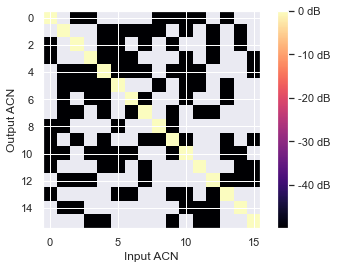

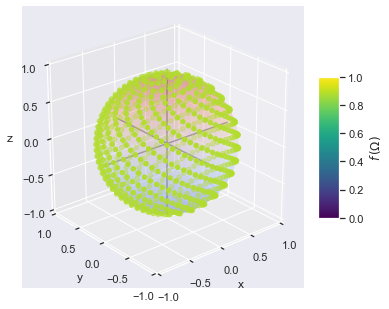

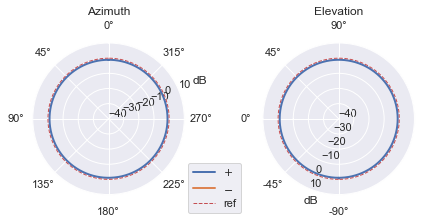

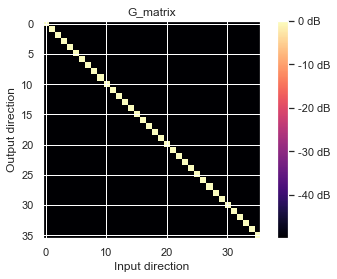

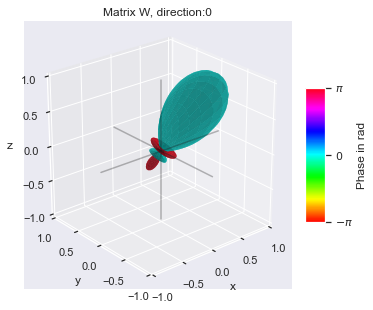

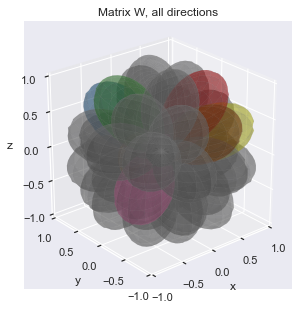

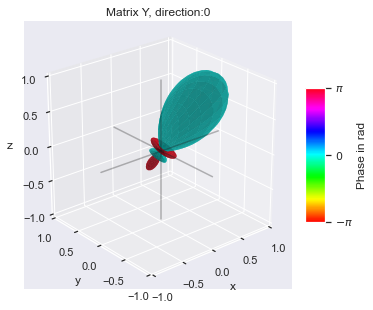

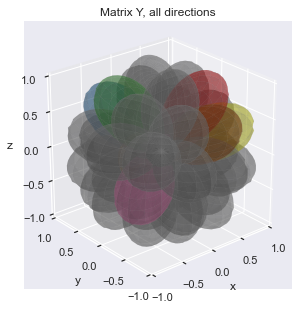

In [10]:
transform = spm.DirectionalLoudness(t_design_degree=params['t_design_degree'], 
                                    G_type=params['G_type'], 
                                    order_output=params['order_output'], 
                                    order_input=params['order_input'], 
                                    backend=params['backend'],
                                    w_pattern=params['w_pattern'])
print(transform)

transform.plot_response(plot_channel=0, plot_matrix=True, do_scaling=True)
transform.plot_G()

selected_direction = 0
spa.plots.sh_coeffs(transform.W[selected_direction,:].numpy(), title=f'Matrix W, direction:{selected_direction}')
spa.plots.sh_coeffs_overlay([*transform.W], title="Matrix W, all directions")
spa.plots.sh_coeffs(transform.Y[selected_direction,:].numpy(), title=f'Matrix Y, direction:{selected_direction}')
spa.plots.sh_coeffs_overlay([*transform.Y], title="Matrix Y, all directions")

#### When G_type = 'identity'

- Here we apply spatial mixup to an input signal that consists of 2 sound sources of white noise.
- When G_type = 'identity', there is no change, and the rms map shows the two sources, at their original positions, with the same level.

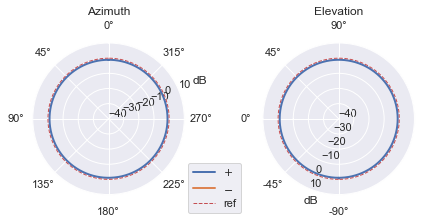

/Users/falconr1/opt/anaconda3/envs/sony/lib/python3.7/site-packages/torch/nn/modules/conv.py:295: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)


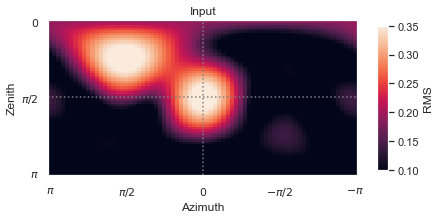

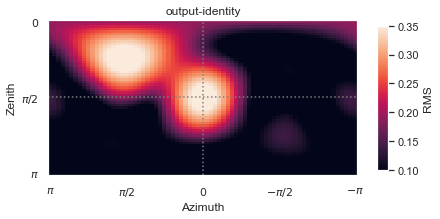

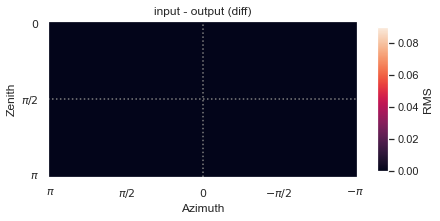

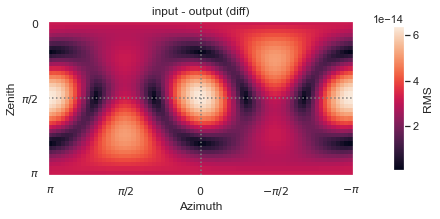

In [3]:
params = {'t_design_degree': 5,
         'G_type': 'identity',
         'order_output': 2,
         'order_input': 2,
         'backend': 'basic',
         'w_pattern': 'hypercardiod',
         'fs': 48000}

transform = spm.DirectionalLoudness(t_design_degree=params['t_design_degree'], 
                                    G_type=params['G_type'], 
                                    order_output=params['order_output'], 
                                    order_input=params['order_input'], 
                                    backend=params['backend'],
                                    w_pattern=params['w_pattern'])
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)


signal_in = utils.get_noise_signal(t_seconds=3, fs=params['fs'], sources_gain=[1, 1], order=params['order_input'])
vmin_rms, vmax_rms = 0.10, 0.35
signal_out = transform.forward(signal_in)

# Plot RMS maps of input, output, and difference
plots.sh_rms_map(signal_in, INDB=False, title='Input', vmin=vmin_rms, vmax=vmax_rms)
plots.sh_rms_map(signal_out, INDB=False, title='output-identity', vmin=vmin_rms, vmax=vmax_rms)

diff = signal_in - signal_out.numpy()
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5, vmin=0, vmax=0.09)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5)


# Listen to the signals:
signal_in_binaural = utils.sh_sig_to_binaural(torch.from_numpy(signal_in), order=params['order_output'], 
                                              device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
signal_out_binaural = utils.sh_sig_to_binaural(signal_out, order=params['order_output'], 
                                               device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=params['fs']))
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=params['fs']))

#### Using a beamformer

- Here we use a regular beamformer, by manually setting G to a single direction in the grid.
- In practice, the beamformer depends on the order of the signal and the selected W matrix, but here it has a hypercardiod response.
- The source located at the front is more of less preserved, but the level is lower, because the beam is pointing downwards.
- The source on the top left is greatly supressed.
- By listening to the binarual output, the spatial characteristics are quite different, much more focused to the front.

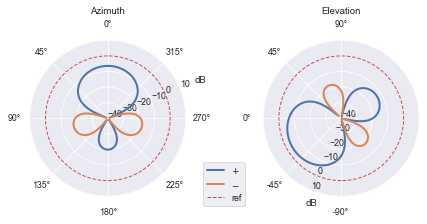

torch.Size([9, 9])
(9, 144000)
torch.Size([9, 144000])


/Users/falconr1/Documents/SonyInternship/Spatial-Mixup-Pytorch/source/spaudiopy/spaudiopy/plots.py:528: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(azi_plot, zen_plot, np.reshape(rms_d, azi_plot.shape))


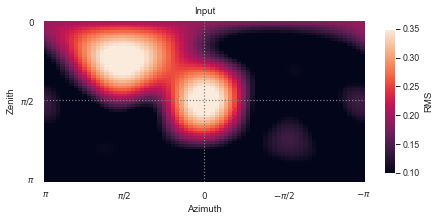

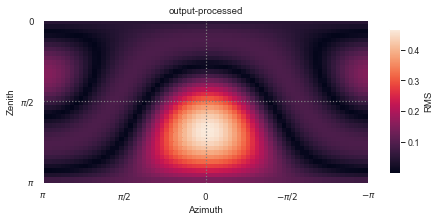

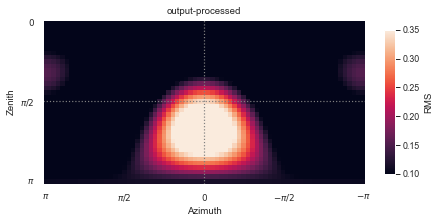

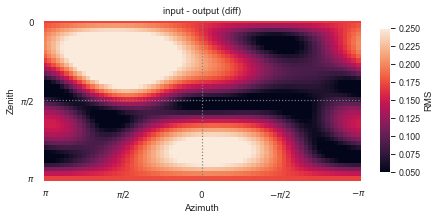

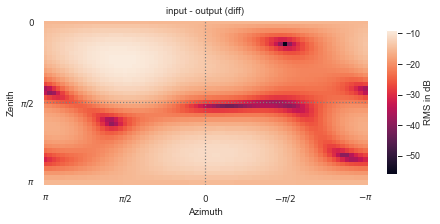

In [19]:
# This is like a regular beamformer, so there is a lot of change
values = np.zeros_like(transform.G.diag())
values[0] = 1
transform.reset_G(G_type='fixed', G_values=values)
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)
signal_out = transform.forward(signal_in)
#signal_out = transform.T_mat @ signal_in
signal_out = signal_out / signal_out.abs().max()
print(transform.T_mat.shape)
print(signal_in.shape)
print(signal_out.shape)

plots.sh_rms_map(signal_in, INDB=False, title='Input', vmin=vmin_rms, vmax=vmax_rms)
spa.plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5)
plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5, vmin=vmin_rms, vmax=vmax_rms)
# Compared difference in signal
diff = signal_in - signal_out.numpy()
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5, vmin=0.05, vmax=0.25)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=True, azi_steps=5, zen_steps=5)

# Listen to the signals:
signal_in_binaural = utils.sh_sig_to_binaural(torch.from_numpy(signal_in), order=params['order_output'], 
                                              device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
signal_out_binaural = utils.sh_sig_to_binaural(signal_out, order=params['order_output'], 
                                               device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=params['fs']))
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=params['fs']))

#### When G_Type = Spherical Caps Soft

- Here we change the directional loudness using a soft spherical cap, pointing to the same direction as the previous beamformer.
- he source located at the front is more of less preserved, but the level is lower, because the beam is pointing downwards.
- The source on the top left is suppresed slightly, but still quite present.
- By listening to the binarual output, the spatial characteristics are slightly different, but pretty similar to the input.

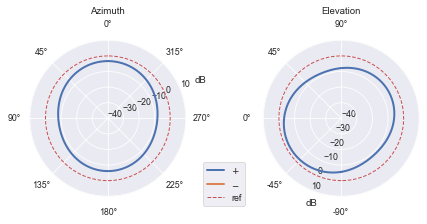

/Users/falconr1/Documents/SonyInternship/Spatial-Mixup-Pytorch/source/spaudiopy/spaudiopy/plots.py:528: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  p = ax.pcolormesh(azi_plot, zen_plot, np.reshape(rms_d, azi_plot.shape))


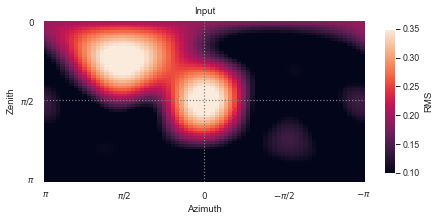

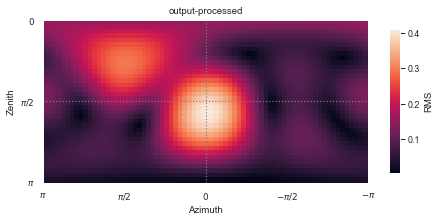

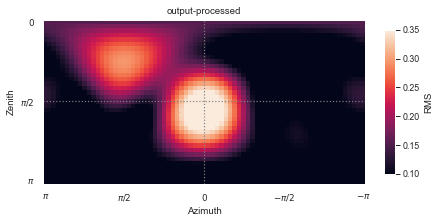

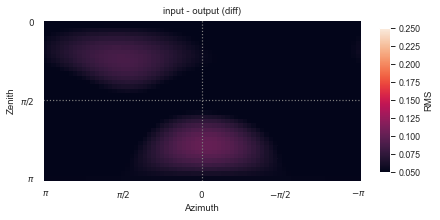

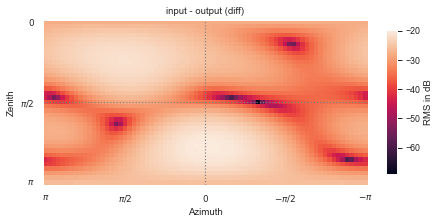

In [22]:
# Manually set parameters for a soft spherical cap
cap_center = torch.tensor([[0, -np.pi/4]])
cap_width = torch.tensor(np.pi/2)
g1_db = 0
g2_db = -6
transform.reset_G(G_type='spherical_cap', capsule_center=cap_center, capsule_width=cap_width, g1_db=g1_db, g2_db=g2_db)
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)
signal_out = transform.forward(np.copy(signal_in))
signal_out = signal_out / signal_out.abs().max()

plots.sh_rms_map(signal_in, INDB=False, title='Input', vmin=vmin_rms, vmax=vmax_rms)
spa.plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5)
plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5, vmin=vmin_rms, vmax=vmax_rms)

# Compared difference in signal
diff = signal_in - signal_out.numpy()
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5, vmin=0.05, vmax=0.25)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=True, azi_steps=5, zen_steps=5)

# Listen to the signals
signal_in_binaural = utils.sh_sig_to_binaural(torch.from_numpy(signal_in), order=params['order_output'], 
                                              device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
signal_out_binaural = utils.sh_sig_to_binaural(signal_out, order=params['order_output'], 
                                               device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=params['fs']))
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=params['fs']))


#### When G_Type = Spherical Caps Hard

- Here we change the directional loudness using a hard spherical cap, pointing to the same direction as the previous soft spherical cap.
- This pattern is more directional than the soft spherical cap, but not as much as the beamformer.
- However, the sound scene is quite different. The source in the top left is mostly suppressed.

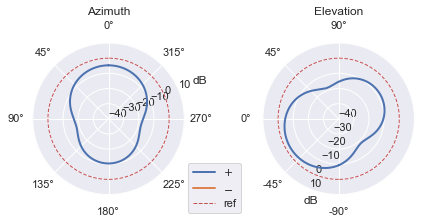

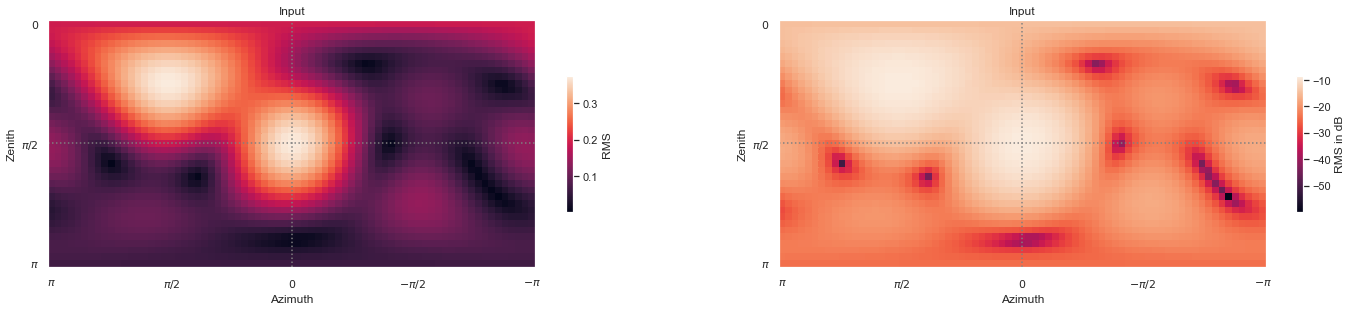

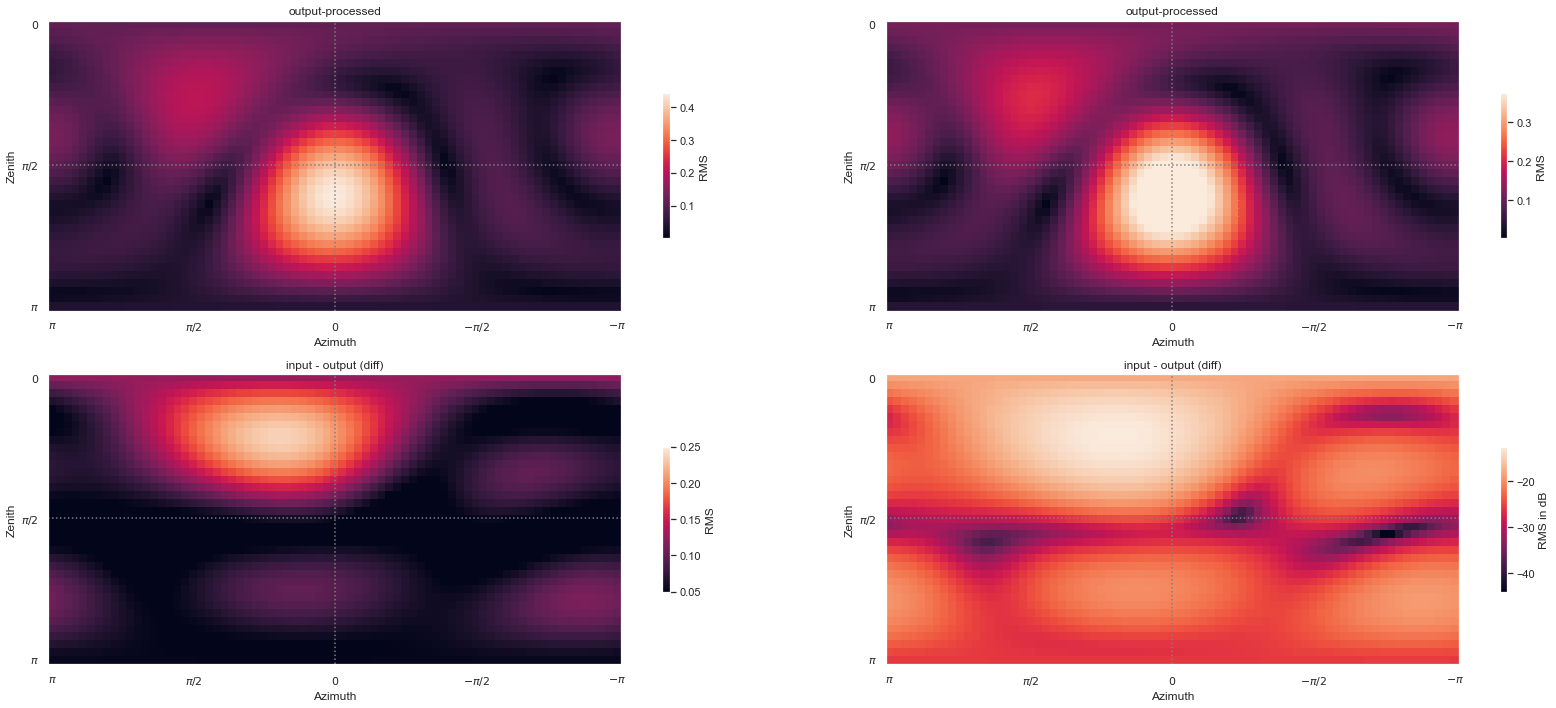

In [29]:
# Manually set parameters for a hard spherical cap
cap_center = torch.tensor([[0, -np.pi/4]])
cap_width = torch.tensor(np.pi/2)
g1_db = 0
g2_db = -12
transform.reset_G(G_type='spherical_cap', capsule_center=cap_center, capsule_width=cap_width, g1_db=g1_db, g2_db=g2_db)
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)
signal_out = transform.forward(np.copy(signal_in))
signal_out = signal_out / signal_out.abs().max()


fig = plt.figure(figsize=(24,5))
plt.subplot(121)
vmin_rms, vmax_rms = plots.sh_rms_map(signal_in, title='Input', INDB=False, azi_steps=5, zen_steps=5, return_values=True, fig=fig)
plt.subplot(122)
plots.sh_rms_map(signal_in, title='Input', INDB=True, azi_steps=5, zen_steps=5, return_values=True, fig=fig)
plt.show()


fig = plt.figure(figsize=(24,10))
plt.subplot(221)
spa.plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5, fig=fig)
plt.subplot(222)
plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5, fig=fig, vmin=vmin_rms, vmax=vmax_rms)

# Compared difference in signal
diff = np.abs(signal_in - signal_out.numpy())
plt.subplot(223)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5, fig=fig, vmin=0.05, vmax=0.25)
plt.subplot(224)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=True, azi_steps=5, zen_steps=5, fig=fig)
plt.tight_layout()

# Listen to the signals:
signal_in_binaural = utils.sh_sig_to_binaural(torch.from_numpy(signal_in), order=params['order_output'], 
                                              device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
signal_out_binaural = utils.sh_sig_to_binaural(signal_out, order=params['order_output'], 
                                               device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=params['fs']))
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=params['fs']))

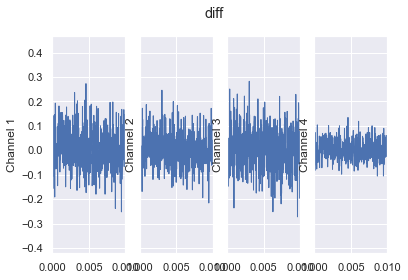

[ -22.09610188  -23.52733738  -21.11888755  -28.42525055 -334.12900923
  -19.5479373   -25.56684342  -16.86160772  -31.61692972]


In [15]:
channels = [0,1,2,3]
plots.plot_waveform(diff[channels,:], sample_rate=48000, xlim=[0, 0.01], title='diff')
coso = spa.utils.rms(diff)
yolo = spa.utils.db(coso)
yolo2 = 20 * np.log10(np.abs(coso) / np.max(np.abs(coso)))
print(yolo)


[  -5.23449416   -6.66572966   -4.25727983  -11.56364283 -317.26740151
   -2.68632958   -8.7052357     0.          -14.755322  ]


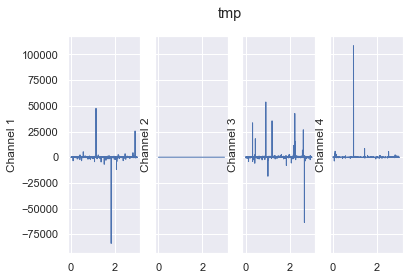

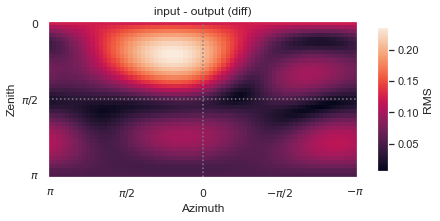

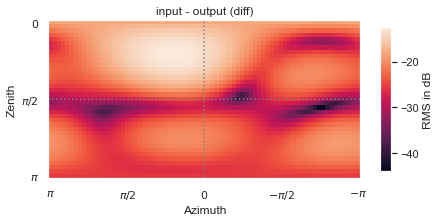

In [26]:
print(yolo2)


diffo = np.abs(signal_in - signal_out.numpy())
cosingo = diffo / signal_in
plots.plot_waveform(cosingo[channels,:], sample_rate=48000, title='tmp')

plots.sh_rms_map(diffo, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5)
plots.sh_rms_map(diffo, title='input - output (diff)', INDB=True, azi_steps=5, zen_steps=5)

# Bonus example: Using a spatial filterbank

- Here we use a spatial filterbank and a strong pattern

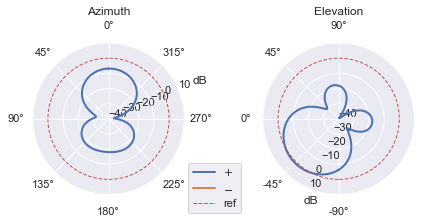

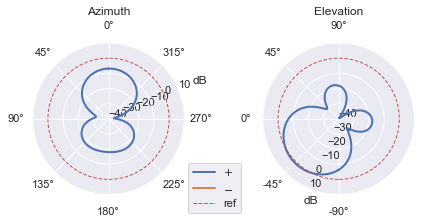

/Users/falconr1/opt/anaconda3/envs/sony/lib/python3.7/site-packages/torch/nn/modules/conv.py:295: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459064158/work/aten/src/ATen/native/Convolution.cpp:660.)
  self.padding, self.dilation, self.groups)


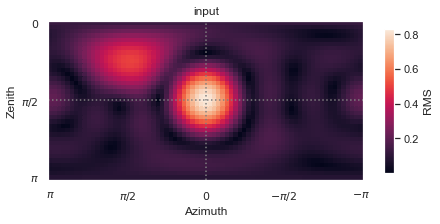

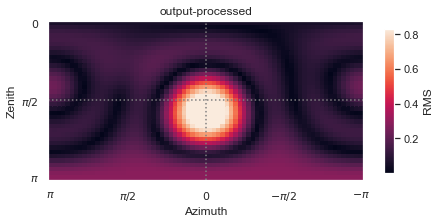

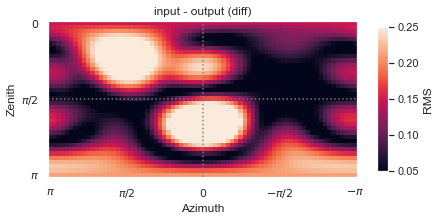

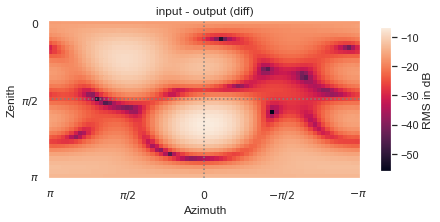

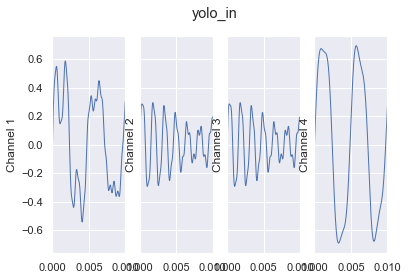

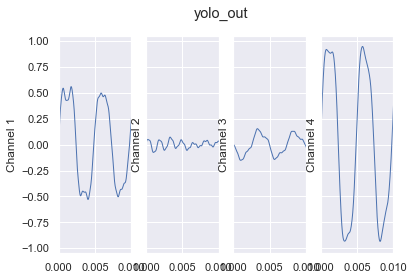

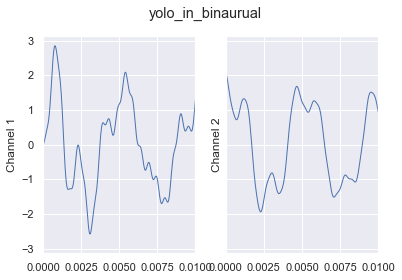

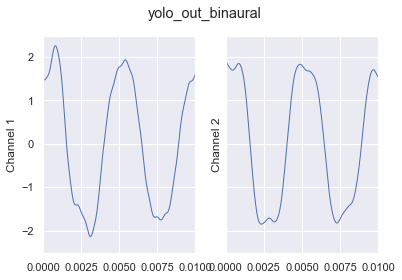

In [7]:
params = {'t_design_degree': 20,
         'G_type': 'spherical_cap_hard',
         'order_output': 3,
         'order_input': 3,
         'backend': 'spatial_filterbank',
         'w_pattern': 'hypercardioid',
         'fs': 48000}
# Manually set parameters for a hard spherical cap
cap_center = torch.tensor([[0, -np.pi/4]])
cap_width = torch.tensor(np.pi/2)
g1_db = 0
g2_db = -20

transform = spm.DirectionalLoudness(t_design_degree=params['t_design_degree'], 
                                    G_type=params['G_type'], 
                                    order_output=params['order_output'], 
                                    order_input=params['order_input'], 
                                    backend=params['backend'],
                                    w_pattern=params['w_pattern'])
transform.reset_G(G_type='spherical_cap', capsule_center=cap_center, capsule_width=cap_width, g1_db=g1_db, g2_db=g2_db)
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)


signal_in = utils.get_fake_sound_scene(t_seconds=3, fs=48000, order=params['order_input'], 
                         sources_gain=[1, 0.6], 
                         sources_freq=[200, 640],
                         sources_direction=[(0, np.pi/2), (np.pi/2, np.pi/4)])
signal_out = transform.forward(np.copy(signal_in))


transform.reset_G(G_type='spherical_cap', capsule_center=cap_center, capsule_width=cap_width, g1_db=g1_db, g2_db=g2_db)
transform.plot_response(plot_channel=0, plot_matrix=False, do_scaling=True, plot3d=False)
signal_out = transform.forward(np.copy(signal_in))
signal_out = signal_out / signal_out.abs().max()


vmin_rms, vmax_rms = plots.sh_rms_map(signal_in, title='input', INDB=False, azi_steps=5, zen_steps=5, return_values=True)
plots.sh_rms_map(signal_out, title='output-processed', INDB=False, azi_steps=5, zen_steps=5, vmin=vmin_rms, vmax=vmax_rms)

# Compared difference in signal
diff = signal_in - signal_out.numpy()
plots.sh_rms_map(diff, title='input - output (diff)', INDB=False, azi_steps=5, zen_steps=5, vmin=0.05, vmax=0.25)
plots.sh_rms_map(diff, title='input - output (diff)', INDB=True, azi_steps=5, zen_steps=5)

# Listen to the signals:
signal_in_binaural = utils.sh_sig_to_binaural(torch.from_numpy(signal_in), order=params['order_output'], 
                                              device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
signal_out_binaural = utils.sh_sig_to_binaural(signal_out, order=params['order_output'], 
                                               device=transform.device, sofa='data/HRIR_L2354.sofa', do_normalize=False)
IPython.display.display(IPython.display.Audio(signal_in_binaural[0, ...].numpy(), rate=params['fs']))
IPython.display.display(IPython.display.Audio(signal_out_binaural[0, ...].numpy(), rate=params['fs']))

channels=[0,1,2,3]
plots.plot_waveform(signal_in[channels,:], sample_rate=48000, xlim=[0, 0.01], title='yolo_in')
plots.plot_waveform(signal_out[channels,:], sample_rate=48000, xlim=[0, 0.01], title='yolo_out')
plots.plot_waveform(signal_in_binaural[0, ...], sample_rate=48000, xlim=[0, 0.01], title='yolo_in_binaurual')
plots.plot_waveform(signal_out_binaural[0, ...], sample_rate=48000, xlim=[0, 0.01], title='yolo_out_binaural')